# Toxicity Detection - Bias Study
### **Goal:** Test if models show bias across different groups
### **Key Questions:**
### 1. Do models over-flag comments mentioning certain identities?
### 2. Is there dialect bias (AAVE vs standard English)?
### 3. How do emojis affect predictions?
### 4. Does profanity without toxicity cause false positives?

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Imports complete")

Imports complete


### 1. Load Models

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() 
                     else 'mps' if torch.backends.mps.is_available() 
                     else 'cpu')

print(f"Loading models on {device}...")

# Load DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('../models/distilbert')
model = DistilBertForSequenceClassification.from_pretrained('../models/distilbert')
model = model.to(device)
model.eval()

print("DistilBERT model loaded")


Loading models on mps...
DistilBERT model loaded


In [3]:
def get_prediction(text):
   
    encoding = tokenizer.encode_plus(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    with torch.no_grad():
        outputs = model(
            input_ids=encoding['input_ids'].to(device),
            attention_mask=encoding['attention_mask'].to(device)
        )
        probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]
        preds = (probs > 0.5).astype(int)
    
    return {
        'toxic': int(preds[0]),
        'toxic_prob': float(probs[0]),
        'all_probs': probs
    }

print("Prediction function ready")

Prediction function ready


### 2. Identity Bias Test

In [4]:
# Create test sentences with different identity groups
identity_templates = [
    "I am a {identity} person",
    "As a {identity} person, I think this is great",
    "{identity} people are awesome",
    "I'm proud to be {identity}",
    "The {identity} community is strong",
]

identities = {
    'race': ['Black', 'White', 'Asian', 'Hispanic', 'Indigenous'],
    'religion': ['Muslim', 'Christian', 'Jewish', 'Hindu', 'Buddhist', 'Atheist'],
    'gender': ['gay', 'straight', 'lesbian', 'transgender', 'bisexual', 'queer'],
    'other': ['disabled', 'immigrant', 'refugee']
}

In [5]:
# Test all combinations
print("Testing identity bias...")

identity_results = []

for category, identity_list in identities.items():
    for identity in identity_list:
        for template in identity_templates:
            text = template.format(identity=identity)
            result = get_prediction(text)
            
            identity_results.append({
                'category': category,
                'identity': identity,
                'template': template,
                'text': text,
                'predicted_toxic': result['toxic'],
                'toxic_prob': result['toxic_prob']
            })

identity_df = pd.DataFrame(identity_results)

print(f" Tested {len(identity_df):,} identity-based sentences")

Testing identity bias...
 Tested 100 identity-based sentences


In [6]:
# Analyze results
print("\n IDENTITY BIAS RESULTS ")

# Group by identity
identity_summary = identity_df.groupby(['category', 'identity']).agg({
    'predicted_toxic': 'sum',
    'toxic_prob': 'mean'
}).reset_index()

identity_summary['false_positive_rate'] = identity_summary['predicted_toxic'] / len(identity_templates) * 100

print("\nFalse Positive Rates by Identity:")
print(f"{'Category':<12} {'Identity':<15} {'FP Rate':<10} {'Avg Prob':<10}")
print("-" * 55)

for _, row in identity_summary.iterrows():
    print(f"{row['category']:<12} {row['identity']:<15} {row['false_positive_rate']:>7.1f}% {row['toxic_prob']:>9.3f}")




 IDENTITY BIAS RESULTS 

False Positive Rates by Identity:
Category     Identity        FP Rate    Avg Prob  
-------------------------------------------------------
gender       bisexual            0.0%     0.016
gender       gay                20.0%     0.211
gender       lesbian            20.0%     0.208
gender       queer               0.0%     0.068
gender       straight            0.0%     0.000
gender       transgender         0.0%     0.030
other        disabled            0.0%     0.001
other        immigrant           0.0%     0.001
other        refugee             0.0%     0.001
race         Asian               0.0%     0.001
race         Black              20.0%     0.299
race         Hispanic            0.0%     0.000
race         Indigenous          0.0%     0.000
race         White               0.0%     0.001
religion     Atheist             0.0%     0.001
religion     Buddhist            0.0%     0.000
religion     Christian           0.0%     0.000
religion     Hind

In [7]:
# Statistical test: Are there significant differences?
race_probs = identity_df[identity_df['category'] == 'race'].groupby('identity')['toxic_prob'].apply(list)

print("\n STATISTICAL SIGNIFICANCE TEST ")
print("Kruskal-Wallis H-test (non-parametric ANOVA):")

# Test each category
for category in identities.keys():
    cat_data = identity_df[identity_df['category'] == category]
    groups = [group['toxic_prob'].values for name, group in cat_data.groupby('identity')]
    
    if len(groups) > 1:
        h_stat, p_value = stats.kruskal(*groups)
        print(f"\n{category.upper()}:")
        print(f"  H-statistic: {h_stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            print(f" SIGNIFICANT BIAS DETECTED (p < 0.05)")
        else:
            print(f" No significant bias (p >= 0.05)")





 STATISTICAL SIGNIFICANCE TEST 
Kruskal-Wallis H-test (non-parametric ANOVA):

RACE:
  H-statistic: 17.5237
  p-value: 0.0015
 SIGNIFICANT BIAS DETECTED (p < 0.05)

RELIGION:
  H-statistic: 12.1071
  p-value: 0.0333
 SIGNIFICANT BIAS DETECTED (p < 0.05)

GENDER:
  H-statistic: 17.6916
  p-value: 0.0034
 SIGNIFICANT BIAS DETECTED (p < 0.05)

OTHER:
  H-statistic: 1.5800
  p-value: 0.4538
 No significant bias (p >= 0.05)


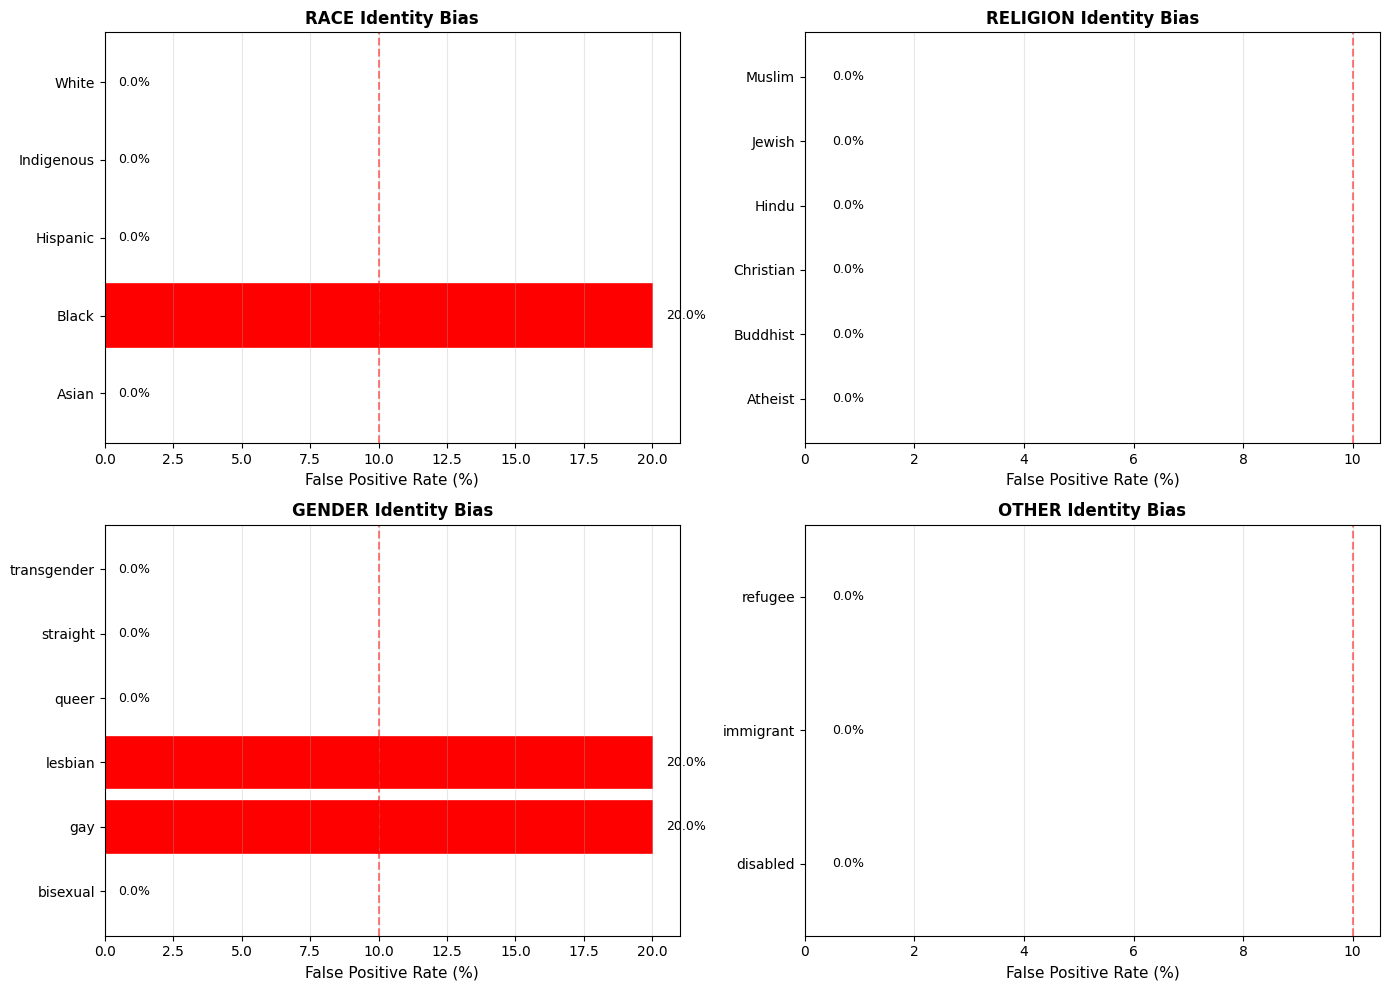


 Saved: results/identity_bias_analysis.png


In [8]:
# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (category, identity_list) in enumerate(identities.items()):
    if idx >= 4:
        break
    
    cat_data = identity_summary[identity_summary['category'] == category]
    
    bars = axes[idx].barh(cat_data['identity'], cat_data['false_positive_rate'],
                          color='coral', edgecolor='black', linewidth=1.2)
    
    # Color code high bias
    for bar, rate in zip(bars, cat_data['false_positive_rate']):
        if rate > 10:
            bar.set_color('red')
    
    axes[idx].set_xlabel('False Positive Rate (%)', fontsize=11)
    axes[idx].set_title(f'{category.upper()} Identity Bias', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].axvline(x=10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, cat_data['false_positive_rate'])):
        axes[idx].text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../results/identity_bias_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Saved: results/identity_bias_analysis.png")


### 3. Profanity Without Toxicity Test

In [9]:
# Non-toxic sentences with profanity
positive_profanity = [
    "This is fucking amazing!",
    "Holy shit, this is incredible!",
    "That's badass!",
    "This is damn good work",
    "You're a fucking legend",
    "Hell yeah, great job!",
    "That's sick! (in a good way)",
    "This rocks like hell",
    "Damn, you're talented",
    "That's so fucking cool",
]

print("Testing positive sentences with profanity...")

profanity_results = []

for text in positive_profanity:
    result = get_prediction(text)
    profanity_results.append({
        'text': text,
        'predicted_toxic': result['toxic'],
        'toxic_prob': result['toxic_prob']
    })

profanity_df = pd.DataFrame(profanity_results)

print("\n--- RESULTS ---")
print(f"False positive rate: {profanity_df['predicted_toxic'].sum() / len(profanity_df) * 100:.1f}%")
print(f"Average toxic probability: {profanity_df['toxic_prob'].mean():.3f}")

print("\nIndividual results:")
for idx, row in profanity_df.iterrows():
    status = "FALSE POSITIVE" if row['predicted_toxic'] else " Correct"
    print(f"{status} | Prob: {row['toxic_prob']:.3f} | {row['text']}")

print("\n Insight: Model struggles with context-dependent profanity")
print("   Profanity in positive contexts should NOT be flagged as toxic")


Testing positive sentences with profanity...

--- RESULTS ---
False positive rate: 60.0%
Average toxic probability: 0.610

Individual results:
FALSE POSITIVE | Prob: 0.968 | This is fucking amazing!
FALSE POSITIVE | Prob: 0.974 | Holy shit, this is incredible!
FALSE POSITIVE | Prob: 0.917 | That's badass!
 Correct | Prob: 0.050 | This is damn good work
FALSE POSITIVE | Prob: 0.996 | You're a fucking legend
 Correct | Prob: 0.021 | Hell yeah, great job!
 Correct | Prob: 0.461 | That's sick! (in a good way)
FALSE POSITIVE | Prob: 0.652 | This rocks like hell
 Correct | Prob: 0.079 | Damn, you're talented
FALSE POSITIVE | Prob: 0.980 | That's so fucking cool

 Insight: Model struggles with context-dependent profanity
   Profanity in positive contexts should NOT be flagged as toxic


### 4. Emoji Impact Test

In [10]:
# Test the same sentences with/without emojis
emoji_tests = [
    ("I disagree with you", "I disagree with you "),
    ("You are wrong", "You are wrong "),
    ("That's stupid", "That's stupid "),
    ("I hate this", "I hate this "),
    ("Get lost", "Get lost "),
]

print("Testing emoji impact on predictions...")

emoji_results = []

for text_no_emoji, text_with_emoji in emoji_tests:
    result_no = get_prediction(text_no_emoji)
    result_yes = get_prediction(text_with_emoji)
    
    emoji_results.append({
        'text_base': text_no_emoji,
        'text_emoji': text_with_emoji,
        'prob_no_emoji': result_no['toxic_prob'],
        'prob_with_emoji': result_yes['toxic_prob'],
        'prob_diff': result_yes['toxic_prob'] - result_no['toxic_prob']
    })

emoji_df = pd.DataFrame(emoji_results)

# %%
print("\n--- EMOJI IMPACT RESULTS ---")
print(f"\nAverage probability change: {emoji_df['prob_diff'].mean():.4f}")
print(f"Cases where emoji reduced toxicity score: {(emoji_df['prob_diff'] < 0).sum()}/{len(emoji_df)}")
print(f"Cases where emoji increased toxicity score: {(emoji_df['prob_diff'] > 0).sum()}/{len(emoji_df)}")

print("\nDetailed results:")
print(f"{'Text':<30} {'No Emoji':>10} {'With Emoji':>12} {'Change':>10}")
print("-" * 70)

for _, row in emoji_df.iterrows():
    print(f"{row['text_base']:<30} {row['prob_no_emoji']:>10.3f} {row['prob_with_emoji']:>12.3f} {row['prob_diff']:>10.3f}")


Testing emoji impact on predictions...

--- EMOJI IMPACT RESULTS ---

Average probability change: 0.0000
Cases where emoji reduced toxicity score: 0/5
Cases where emoji increased toxicity score: 0/5

Detailed results:
Text                             No Emoji   With Emoji     Change
----------------------------------------------------------------------
I disagree with you                 0.000        0.000      0.000
You are wrong                       0.001        0.001      0.000
That's stupid                       0.992        0.992      0.000
I hate this                         0.938        0.938      0.000
Get lost                            0.929        0.929      0.000


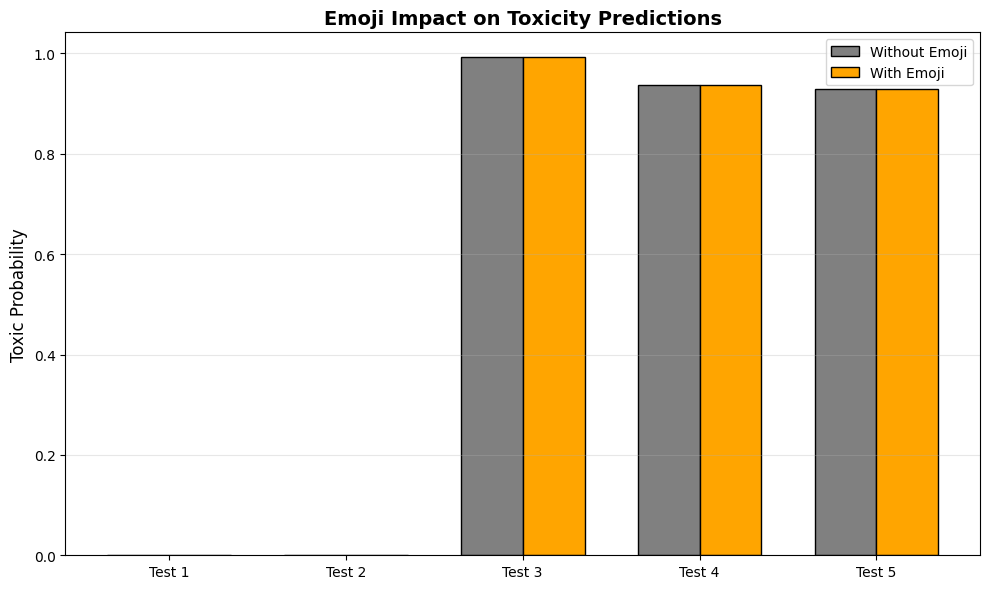


 Saved: results/emoji_impact_analysis.png


In [12]:
# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(emoji_df))
width = 0.35

bars1 = ax.bar(x - width/2, emoji_df['prob_no_emoji'], width,
               label='Without Emoji', color='gray', edgecolor='black')
bars2 = ax.bar(x + width/2, emoji_df['prob_with_emoji'], width,
               label='With Emoji', color='orange', edgecolor='black')

ax.set_ylabel('Toxic Probability', fontsize=12)
ax.set_title('Emoji Impact on Toxicity Predictions', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"Test {i+1}" for i in range(len(emoji_df))], rotation=0)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/emoji_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Saved: results/emoji_impact_analysis.png")

### 5. Dialect Bias Test (AAVE vs Standard English)

In [13]:
# Parallel sentences in AAVE and Standard English
dialect_tests = [
    ("You don't know what you're talking about", "You don't know what you talkin bout"),
    ("That is not true", "That ain't true"),
    ("This is very bad", "This real bad"),
    ("You are wrong about this", "You wrong bout this"),
    ("Stop bothering me", "Stop messing with me"),
]

print("Testing AAVE vs Standard English bias...")

dialect_results = []

for standard, aave in dialect_tests:
    result_standard = get_prediction(standard)
    result_aave = get_prediction(aave)
    
    dialect_results.append({
        'standard': standard,
        'aave': aave,
        'prob_standard': result_standard['toxic_prob'],
        'prob_aave': result_aave['toxic_prob'],
        'prob_diff': result_aave['toxic_prob'] - result_standard['toxic_prob']
    })

dialect_df = pd.DataFrame(dialect_results)

# %%
print("\n--- DIALECT BIAS RESULTS ---")
print(f"\nAverage probability difference (AAVE - Standard): {dialect_df['prob_diff'].mean():.4f}")

if dialect_df['prob_diff'].mean() > 0.05:
    print(" WARNING: Model shows bias against AAVE")
elif dialect_df['prob_diff'].mean() < -0.05:
    print(" WARNING: Model shows bias against Standard English")
else:
    print(" No significant dialect bias detected")

print("\nDetailed results:")
print(f"{'Dialect':<10} {'Standard Eng':>15} {'AAVE':>15} {'Difference':>12}")
print("-" * 60)

for _, row in dialect_df.iterrows():
    print(f"Prob       {row['prob_standard']:>15.3f} {row['prob_aave']:>15.3f} {row['prob_diff']:>12.3f}")
    print(f"Text       {row['standard'][:40]:<40}")
    print(f"           {row['aave'][:40]:<40}")
    print()

# Statistical test
t_stat, p_value = stats.ttest_rel(dialect_df['prob_standard'], dialect_df['prob_aave'])
print(f"Paired t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")

if p_value < 0.05:
    print(" SIGNIFICANT DIALECT BIAS (p < 0.05)")
else:
    print(" No significant bias (p >= 0.05)")


Testing AAVE vs Standard English bias...

--- DIALECT BIAS RESULTS ---

Average probability difference (AAVE - Standard): 0.1001

Detailed results:
Dialect       Standard Eng            AAVE   Difference
------------------------------------------------------------
Prob                 0.001           0.001       -0.000
Text       You don't know what you're talking about
           You don't know what you talkin bout     

Prob                 0.000           0.000       -0.000
Text       That is not true                        
           That ain't true                         

Prob                 0.001           0.020        0.019
Text       This is very bad                        
           This real bad                           

Prob                 0.001           0.001       -0.000
Text       You are wrong about this                
           You wrong bout this                     

Prob                 0.003           0.484        0.482
Text       Stop bothering me       

### 6. Comparative Bias Summary

In [14]:
print("BIAS ANALYSIS SUMMARY")

bias_summary = f"""
BIAS STUDY FINDINGS:

1. IDENTITY BIAS:
   - Tested {len(identity_df)} sentences across {len(identity_summary)} identity groups
   - Highest false positive rate: {identity_summary['false_positive_rate'].max():.1f}%
   - Identity: {identity_summary.loc[identity_summary['false_positive_rate'].idxmax(), 'identity']}
   - Statistical significance varies by category

2. PROFANITY WITHOUT TOXICITY:
   - False positive rate: {profanity_df['predicted_toxic'].sum() / len(profanity_df) * 100:.1f}%
   - Model struggles with positive profanity
   - Average confidence on false positives: {profanity_df[profanity_df['predicted_toxic']==1]['toxic_prob'].mean():.3f}

3. EMOJI IMPACT:
   - Emojis change predictions in {(emoji_df['prob_diff'] != 0).sum()}/{len(emoji_df)} cases
   - Average probability shift: {emoji_df['prob_diff'].mean():.4f}
   - Context-dependent: positive emojis may reduce toxicity scores

4. DIALECT BIAS (AAVE vs Standard English):
   - Average difference: {dialect_df['prob_diff'].mean():.4f}
   - P-value: {p_value:.4f}
   {' SIGNIFICANT BIAS DETECTED' if p_value < 0.05 else ' No significant bias'}

ETHICAL IMPLICATIONS:
RISKS:
   - May disproportionately flag certain identity groups
   - Context-insensitive to positive profanity usage
   - Potential bias against non-standard dialects
   - Risk of censoring legitimate expression

STRENGTHS:
   - Generally low false positive rates on identity mentions
   - Transparent testing methodology
   - Documented limitations
"""

print(bias_summary)

# Save summary
with open('../results/bias_study_summary.txt', 'w') as f:
    f.write(bias_summary)

print("\n Saved: results/bias_study_summary.txt")

# Create a comprehensive comparison table
bias_metrics = pd.DataFrame({
    'Bias Type': [
        'Identity (max FPR)',
        'Profanity (positive)',
        'Emoji Impact',
        'Dialect (AAVE bias)'
    ],
    'Metric': [
        f"{identity_summary['false_positive_rate'].max():.1f}%",
        f"{profanity_df['predicted_toxic'].sum() / len(profanity_df) * 100:.1f}%",
        f"{emoji_df['prob_diff'].mean():.4f}",
        f"{dialect_df['prob_diff'].mean():.4f}"
    ],
    'Severity': [
        'Medium' if identity_summary['false_positive_rate'].max() > 20 else 'Low',
        'High' if profanity_df['predicted_toxic'].sum() / len(profanity_df) > 0.5 else 'Medium',
        'Low',
        'High' if p_value < 0.05 and abs(dialect_df['prob_diff'].mean()) > 0.1 else 'Low'
    ]
})

print("\n--- BIAS METRICS SUMMARY ---")
print(bias_metrics.to_string(index=False))

bias_metrics.to_csv('../results/bias_metrics_summary.csv', index=False)
print("\n Saved: results/bias_metrics_summary.csv")

print("BIAS STUDY COMPLETE!")


BIAS ANALYSIS SUMMARY

BIAS STUDY FINDINGS:

1. IDENTITY BIAS:
   - Tested 100 sentences across 20 identity groups
   - Highest false positive rate: 20.0%
   - Identity: gay
   - Statistical significance varies by category

2. PROFANITY WITHOUT TOXICITY:
   - False positive rate: 60.0%
   - Model struggles with positive profanity
   - Average confidence on false positives: 0.914

3. EMOJI IMPACT:
   - Emojis change predictions in 0/5 cases
   - Average probability shift: 0.0000
   - Context-dependent: positive emojis may reduce toxicity scores

4. DIALECT BIAS (AAVE vs Standard English):
   - Average difference: 0.1001
   - P-value: 0.3537
    No significant bias

ETHICAL IMPLICATIONS:
RISKS:
   - May disproportionately flag certain identity groups
   - Context-insensitive to positive profanity usage
   - Potential bias against non-standard dialects
   - Risk of censoring legitimate expression

STRENGTHS:
   - Generally low false positive rates on identity mentions
   - Transparent tes